In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import random
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, random_split
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

### Pre-processing

In [3]:
class RetinaPatchDataset(Dataset):
    def __init__(self, image_paths, label_paths, mask_paths, patch_size=48, num_patches=190000):
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.images = []
        self.labels = []
        self.masks = []

        for img_path, lbl_path, msk_path in zip(image_paths, label_paths, mask_paths):
            img = np.array(Image.open(img_path).convert('L'), dtype=np.uint8)[:, 9:574]
            lbl = np.array(Image.open(lbl_path).convert('L'), dtype=np.uint8)[:, 9:574]
            msk = np.array(Image.open(msk_path).convert('L'), dtype=np.uint8)[:, 9:574]

            img = torch.tensor(img, dtype=torch.float32) / 255.0
            lbl = torch.tensor(lbl, dtype=torch.float32) / 255.0
            msk = torch.tensor(msk, dtype=torch.float32) / 255.0

            self.images.append(img)
            self.labels.append(lbl)
            self.masks.append(msk)

    def __len__(self):
        return self.num_patches

    def __getitem__(self, idx):
        while True:
            img_idx = random.randint(0, len(self.images) - 1)
            img = self.images[img_idx]
            lbl = self.labels[img_idx]
            msk = self.masks[img_idx]

            H, W = img.shape
            x = random.randint(0, W - self.patch_size)
            y = random.randint(0, H - self.patch_size)

            patch_img = img[y:y+self.patch_size, x:x+self.patch_size]
            patch_lbl = lbl[y:y+self.patch_size, x:x+self.patch_size]
            patch_msk = msk[y:y+self.patch_size, x:x+self.patch_size]

            if patch_msk.mean() > 0.95:
                break

        return patch_img.unsqueeze(0), patch_lbl.unsqueeze(0)

In [4]:
from glob import glob

image_paths = sorted(glob('/content/drive/MyDrive/med_final/retina_data/DRIVE/training/images/*.tif'))
label_paths = sorted(glob('/content/drive/MyDrive/med_final/retina_data/DRIVE/training/1st_manual/*.gif'))
mask_paths  = sorted(glob('/content/drive/MyDrive/med_final/retina_data/DRIVE/training/mask/*.gif'))

dataset = RetinaPatchDataset(
    image_paths=image_paths,
    label_paths=label_paths,
    mask_paths=mask_paths,
    patch_size=48,
    num_patches=114000
)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

img, mask = train_dataset[0]
print(img.shape, mask.shape)  # should be [1, 48, 48]


torch.Size([1, 48, 48]) torch.Size([1, 48, 48])


### Model initialization

In [5]:
# Recurrent Convolutional Block
class RecurrentBlock(nn.Module):
    def __init__(self, out_channels, t=3):
        super(RecurrentBlock, self).__init__()
        self.t = t
        self.out_channels = out_channels
        self.conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        for i in range(self.t):
            if i == 0:
                out = self.relu(self.bn(self.conv(x)))
            else:
                out = self.relu(self.bn(self.conv(x + out)))
        return out

# Recurrent Residual Convolutional Unit (RRCU)
class RRCU(nn.Module):
    def __init__(self, in_channels, out_channels, t=3):
        super(RRCU, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.rcnn = nn.Sequential(
            RecurrentBlock(out_channels, t),
            RecurrentBlock(out_channels, t)
        )

    def forward(self, x):
        x = self.conv1x1(x)
        out = self.rcnn(x)
        return x + out  # Residual connection


In [6]:
def center_crop(enc_feat, target_size):
    _, _, h, w = enc_feat.size()
    th, tw = target_size
    i = (h - th) // 2
    j = (w - tw) // 2
    return enc_feat[:, :, i:i+th, j:j+tw]

class R2UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, t=3):
        super(R2UNet, self).__init__()

        self.enc1 = RRCU(in_channels, 16, t)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = RRCU(16, 32, t)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = RRCU(32, 64, t)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = RRCU(64, 128, t)

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = RRCU(128 + 64, 64, t)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = RRCU(64 + 32, 32, t)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = RRCU(32 + 16, 16, t)

        self.final = nn.Conv2d(16, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoding path
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Decoding path
        d3 = self.up3(e4)
        e3_cropped = center_crop(e3, d3.shape[2:])
        d3 = self.dec3(torch.cat([d3, e3_cropped], dim=1))

        d2 = self.up2(d3)
        e2_cropped = center_crop(e2, d2.shape[2:])
        d2 = self.dec2(torch.cat([d2, e2_cropped], dim=1))

        d1 = self.up1(d2)
        e1_cropped = center_crop(e1, d1.shape[2:])
        d1 = self.dec1(torch.cat([d1, e1_cropped], dim=1))

        out = self.final(d1)
        return self.sigmoid(out)

In [7]:
model = R2UNet()
x = torch.randn(1, 1, 48, 48)
out = model(x)
print(out.shape)  # should be [1, 1, 48, 48]

torch.Size([1, 1, 48, 48])


In [8]:
criterion = nn.BCELoss()
model = R2UNet(in_channels=1, out_channels=1, t=3).cuda()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

def compute_metrics(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    pred = pred.view(-1)
    target = target.view(-1)

    TP = (pred * target).sum()
    TN = ((1 - pred) * (1 - target)).sum()
    FP = (pred * (1 - target)).sum()
    FN = ((1 - pred) * target).sum()

    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    sensitivity = TP / (TP + FN + 1e-8)
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-8)

    return {
        'accuracy': accuracy.item(),
        'sensitivity': sensitivity.item(),
        'dice': dice.item()
    }


def validate(model, dataloader, criterion):
    model.eval()
    total_metrics = {'accuracy': 0, 'sensitivity': 0, 'dice': 0}
    total_loss = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            metrics = compute_metrics(outputs, masks)
            for k in total_metrics:
                total_metrics[k] += metrics[k]

    num_batches = len(dataloader)
    avg_metrics = {k: v / num_batches for k, v in total_metrics.items()}
    avg_loss = total_loss / num_batches
    return avg_loss, avg_metrics

### Training

In [9]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=30,
          save_path='best_model.pth', patience=5):

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        val_loss, val_metrics = validate(model, val_loader, criterion)

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f} | "
              f"Val Loss={val_loss:.4f} | Dice={val_metrics['dice']:.4f} | "
              f"Acc={val_metrics['accuracy']:.4f} | Sens={val_metrics['sensitivity']:.4f}")

        # Save best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print("Saved best model (based on BCE loss)")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print(f"No improvement for {epochs_without_improvement} epoch(s)")

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

In [10]:
model = R2UNet().cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

train(model, train_loader, val_loader, criterion, optimizer,
      num_epochs=10, save_path='/content/drive/MyDrive/med_final/model/best_model.pth', patience=5)

Epoch 1: Train Loss=0.1698 | Val Loss=0.5737 | Dice=0.1617 | Acc=0.8403 | Sens=0.1169
Saved best model (based on BCE loss)


Epoch 2: Train Loss=0.1209 | Val Loss=0.5681 | Dice=0.1399 | Acc=0.8434 | Sens=0.0960
Saved best model (based on BCE loss)


Epoch 3: Train Loss=0.1104 | Val Loss=0.6597 | Dice=0.0805 | Acc=0.8456 | Sens=0.0517
No improvement for 1 epoch(s)


Epoch 4: Train Loss=0.1026 | Val Loss=0.7210 | Dice=0.0161 | Acc=0.8671 | Sens=0.0082
No improvement for 2 epoch(s)


Epoch 5: Train Loss=0.0965 | Val Loss=0.8081 | Dice=0.0138 | Acc=0.8669 | Sens=0.0070
No improvement for 3 epoch(s)


Epoch 6: Train Loss=0.0922 | Val Loss=0.7601 | Dice=0.0154 | Acc=0.8670 | Sens=0.0079
No improvement for 4 epoch(s)


Epoch 7: Train Loss=0.0885 | Val Loss=0.7348 | Dice=0.0193 | Acc=0.8674 | Sens=0.0098
No improvement for 5 epoch(s)
Early stopping triggered at epoch 7


### Evaluation

In [17]:
import matplotlib.pyplot as plt

def infer_full_image(model, image_path, threshold=0.5):
    model.eval()

    # --- Load and crop test image (to 565x565 as during training) ---
    img = Image.open(image_path).convert('L')
    img = img.crop((9, 0, 574, 565))  # Note: right=574 for 565x565 shape
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_tensor = torch.from_numpy(img_array).unsqueeze(0).unsqueeze(0).to(next(model.parameters()).device)

    # --- Forward pass ---
    with torch.no_grad():
        pred = model(img_tensor)
        pred = torch.sigmoid(pred)
        pred_array = pred.squeeze().cpu().numpy()

    pred_bin = (pred_array > threshold).astype(np.uint8)

    # --- Plot ---
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array, cmap='gray')
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_array, cmap='gray')
    plt.title("Prediction (Probabilities)")

    plt.tight_layout()
    plt.show()

    return pred_bin

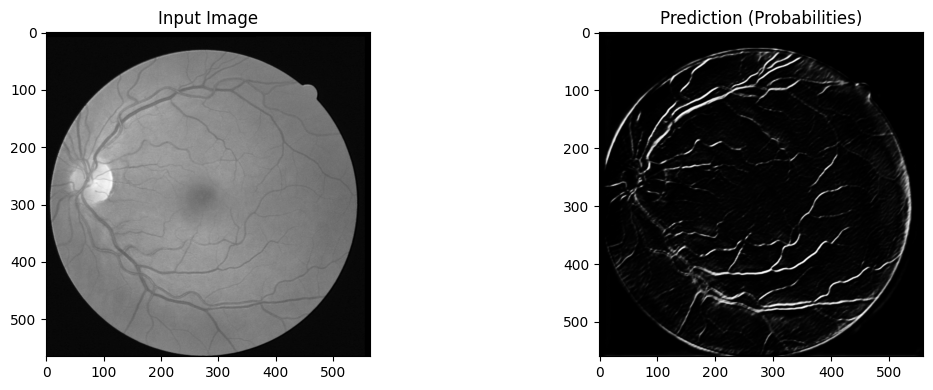

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
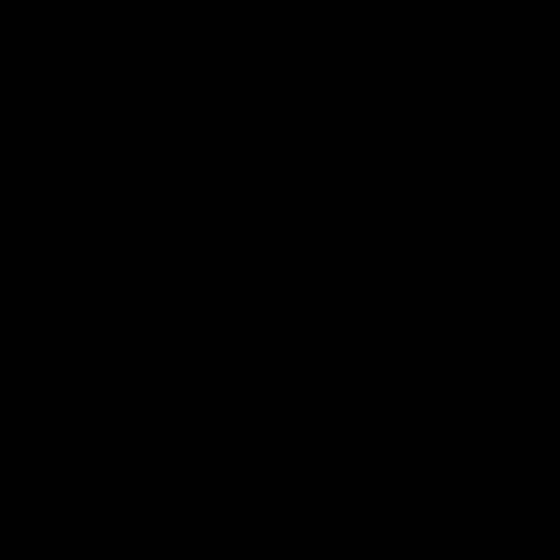

In [18]:
# Load best saved model
model = R2UNet().cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/med_final/model/best_model.pth"))

# Predict on one test image
infer_full_image(
    model,
    image_path='/content/drive/MyDrive/med_final/retina_data/DRIVE/test/images/01_test.tif',
    #gt_path='/content/drive/MyDrive/med_final/retina_data/DRIVE/test/mask/01_test_mask.gif'
)


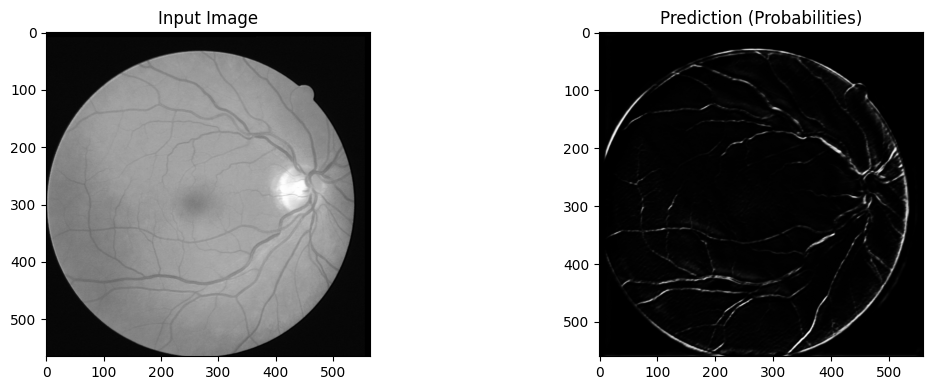

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
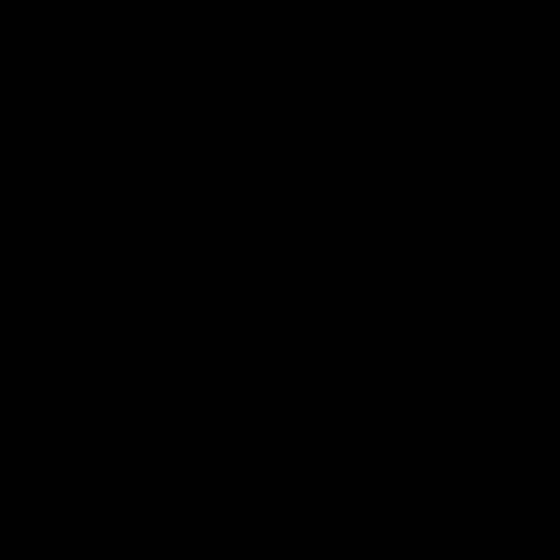

In [19]:
# Load best saved model
model = R2UNet().cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/med_final/model/best_model.pth"))

# Predict on one test image
infer_full_image(
    model,
    image_path='/content/drive/MyDrive/med_final/retina_data/DRIVE/test/images/02_test.tif',
    #gt_path='/content/drive/MyDrive/med_final/retina_data/DRIVE/test/mask/01_test_mask.gif'
)


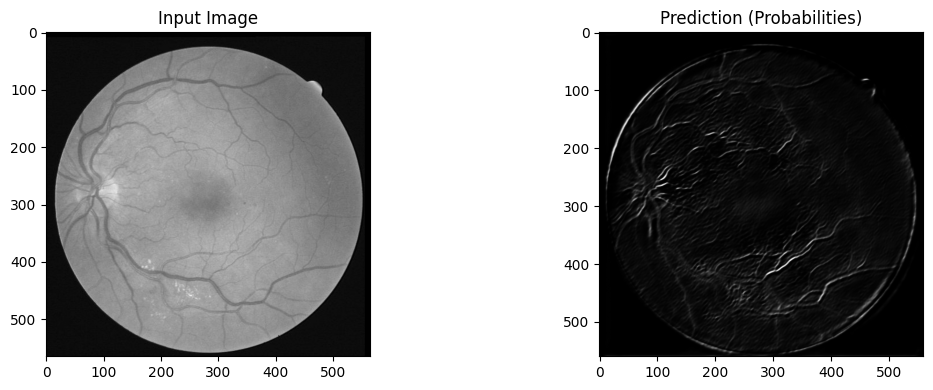

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
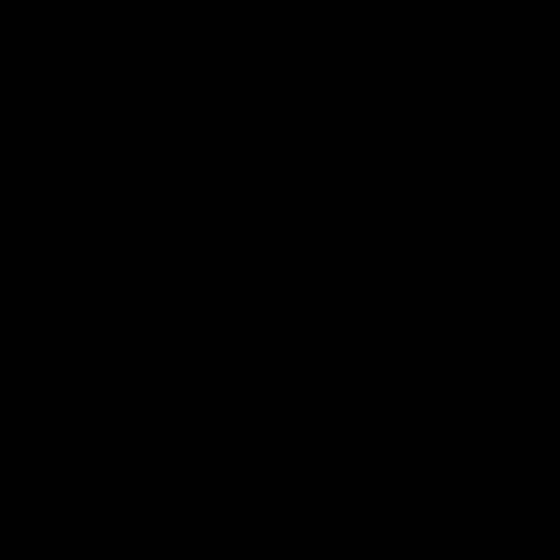

In [20]:
# Load best saved model
model = R2UNet().cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/med_final/model/best_model.pth"))

# Predict on one test image
infer_full_image(
    model,
    image_path='/content/drive/MyDrive/med_final/retina_data/DRIVE/test/images/03_test.tif',
    #gt_path='/content/drive/MyDrive/med_final/retina_data/DRIVE/test/mask/01_test_mask.gif'
)


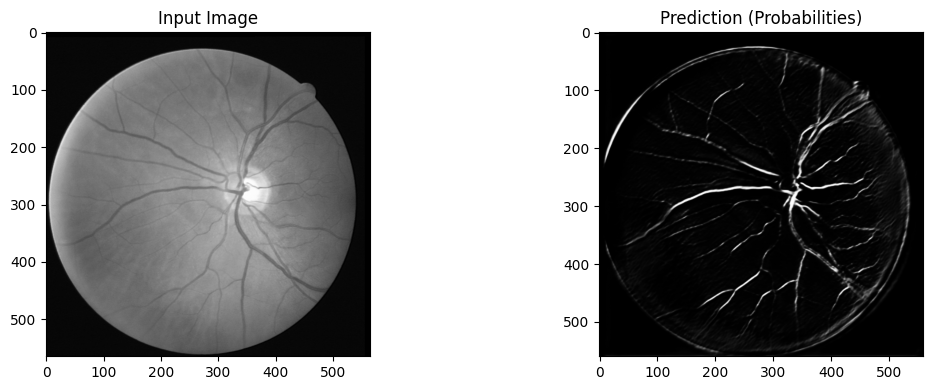

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
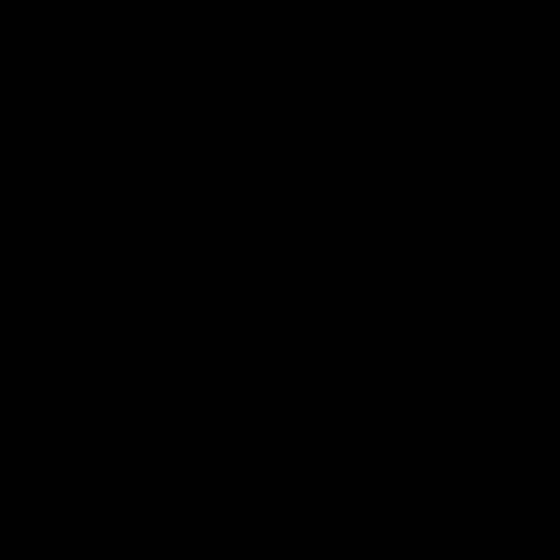

In [21]:
# Load best saved model
model = R2UNet().cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/med_final/model/best_model.pth"))

# Predict on one test image
infer_full_image(
    model,
    image_path='/content/drive/MyDrive/med_final/retina_data/DRIVE/test/images/04_test.tif',
    #gt_path='/content/drive/MyDrive/med_final/retina_data/DRIVE/test/mask/01_test_mask.gif'
)
